Found 551 folders. Processing...

### Comparative Analysis Table (Sample) ###


,ID,C_Vars,Btor_Vars,Ratio_Vars,C_Stmts,Btor_Stmts,Ratio_Stmts
0,Huffman_dec.yml,448,193,0.430804,990,285,0.287879
1,Huffman_enc.yml,240,103,0.429167,516,115,0.222868
2,adding.1.prop1-back-serstep.yml,378,138,0.365079,940,178,0.189362
3,adding.1.prop1-func-interl.yml,307,107,0.348534,760,130,0.171053
4,adding.2.prop1-back-serstep.yml,378,138,0.365079,940,178,0.189362



### Ratio Statistics (Btor/C) for all metrics ###


,Metric,Average,Median,Std Deviation
0,Vars,0.3578,0.3569,0.0138
1,Locs,0.6004,0.6000,0.0085
2,Edges,0.7505,0.7500,0.0107
3,Stmts,0.1782,0.1757,0.0153


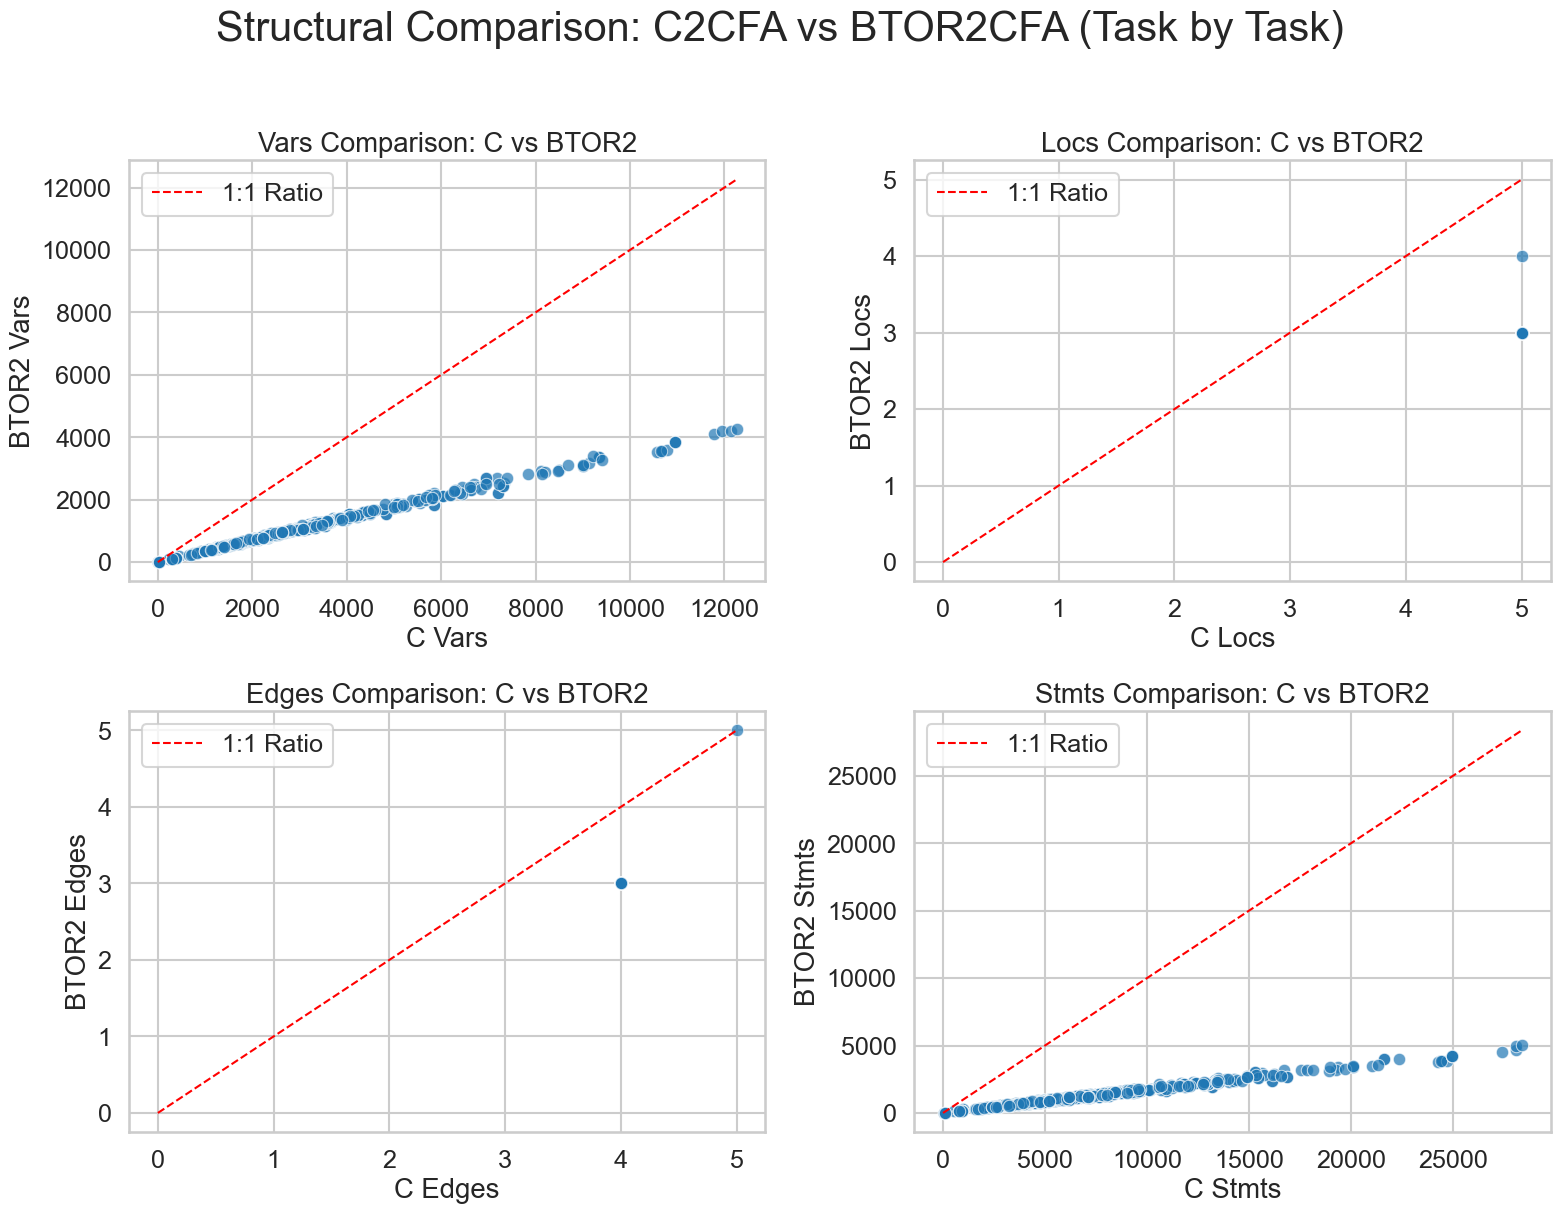

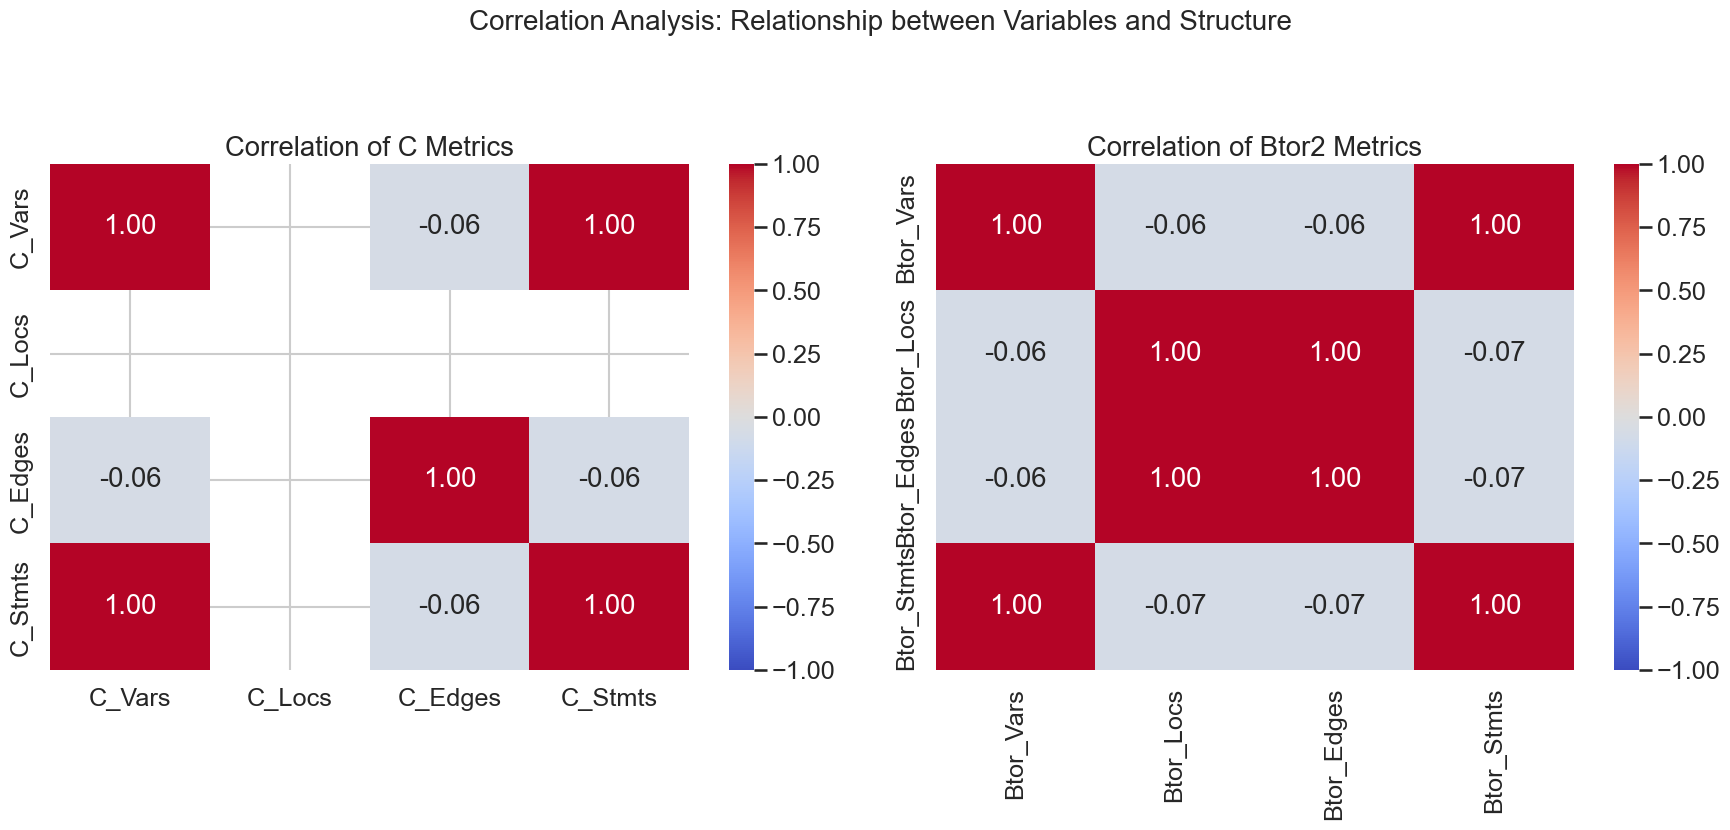

Generating detailed Pairplot (C Metrics)...


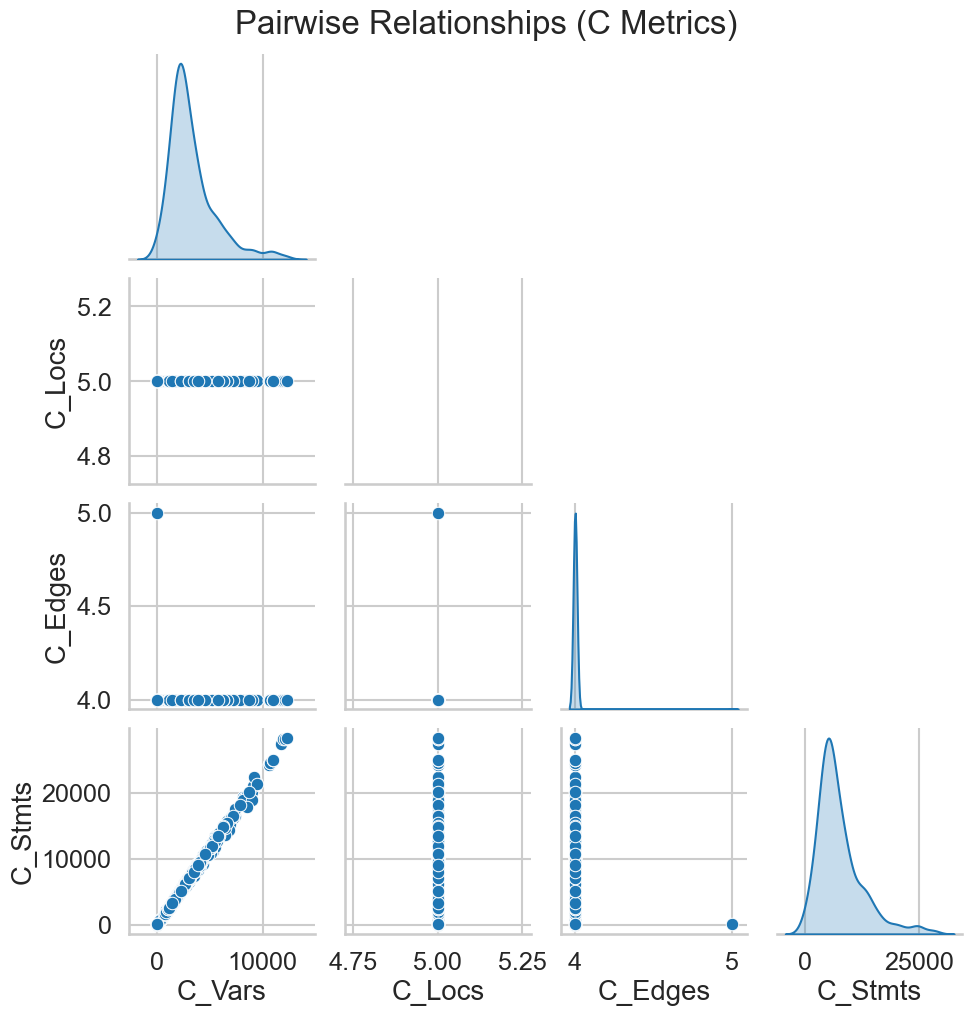

In [4]:
import os
import json
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Update this path to point to the parent folder containing the numbered subfolders (e.g., "000", "001")
ROOT_DIR = "json_files" 

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def get_atomic_instruction_count(label_data):
    """
    Recursively calculates the number of atomic instructions.
    - Unpacks 'SequenceLabel' to count its children.
    - Counts 'StmtLabel' as 1.
    """
    if not label_data:
        return 0
    
    # Get the type of the label
    l_type = label_data.get("type", "")
    
    # Case 1: Sequence Label (contains a list of labels)
    if "SequenceLabel" in l_type:
        sub_labels = label_data.get("labels", [])
        return sum(get_atomic_instruction_count(sub) for sub in sub_labels)
    
    # Case 2: Nondet Label (Choice block, contains a list of labels)
    elif "NondetLabel" in l_type:
        sub_labels = label_data.get("labels", [])
        return sum(get_atomic_instruction_count(sub) for sub in sub_labels)

    # Case 3: Atomic Statement
    elif "StmtLabel" in l_type:
        return 1
    
    # Case 4: Other labels (Empty, Comments, etc.)
    return 0

def parse_xcfa(filepath):
    """
    Parses a single XCFA JSON file and extracts metrics.
    """
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
            
        stats = {
            "vars": 0,
            "locs": 0,
            "edges": 0,
            "atomic_stmts": 0
        }
        
        # Iterate through all procedures (usually 'main')
        for proc in data.get("procedures", []):
            # 1. Count Variables (Vars list + Params list)
            stats["vars"] += len(proc.get("vars", [])) + len(proc.get("params", []))
            
            # 2. Count Locations (Nodes)
            stats["locs"] += len(proc.get("locs", []))
            
            # 3. Count Edges
            edges = proc.get("edges", [])
            stats["edges"] += len(edges)
            
            # 4. Count Atomic Instructions (Recursive Label Analysis)
            for edge in edges:
                label = edge.get("label", {})
                stats["atomic_stmts"] += get_atomic_instruction_count(label)
                
        return stats
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

# ==========================================
# 3. MAIN PROCESSING LOOP
# ==========================================

data_rows = []

# Find all subdirectories
if os.path.exists(ROOT_DIR):
    subfolders = sorted([f.path for f in os.scandir(ROOT_DIR) if f.is_dir()])
    print(f"Found {len(subfolders)} folders. Processing...")
else:
    subfolders = []
    print(f"Directory {ROOT_DIR} not found.")

for folder in subfolders:
    folder_name = os.path.basename(folder)
    
    # Define paths for the pair
    c_path = os.path.join(folder, "c-xcfa.json")
    btor_path = os.path.join(folder, "btor2-xcfa.json")
    
    # Proceed only if both files exist
    if os.path.exists(c_path) and os.path.exists(btor_path):
        c_stats = parse_xcfa(c_path)
        btor_stats = parse_xcfa(btor_path)
        
        if c_stats and btor_stats:
            data_rows.append({
                "ID": folder_name,
                # C Metrics
                "C_Vars": c_stats["vars"],
                "C_Locs": c_stats["locs"],
                "C_Edges": c_stats["edges"],
                "C_Stmts": c_stats["atomic_stmts"],
                # BTOR2 Metrics
                "Btor_Vars": btor_stats["vars"],
                "Btor_Locs": btor_stats["locs"],
                "Btor_Edges": btor_stats["edges"],
                "Btor_Stmts": btor_stats["atomic_stmts"],
            })

# Create DataFrame
df = pd.DataFrame(data_rows)

# ==========================================
# 4. DATA ANALYSIS & RATIOS
# ==========================================

if not df.empty:
    # Calculate Ratios for ALL metrics (Btor / C)
    metrics = ["Vars", "Locs", "Edges", "Stmts"]
    for metric in metrics:
        df[f"Ratio_{metric}"] = df[f"Btor_{metric}"] / df[f"C_{metric}"]

    # --- 4a. Comparative Data Table ---
    print("\n### Comparative Analysis Table (Sample) ###")
    display_cols = ["ID", "C_Vars", "Btor_Vars", "Ratio_Vars", 
                    "C_Stmts", "Btor_Stmts", "Ratio_Stmts"]
    display(df[display_cols].head())

    # --- 4b. Ratio Statistics (Mean, Median, Std) ---
    print("\n### Ratio Statistics (Btor/C) for all metrics ###")
    stats_rows = []
    for metric in metrics:
        col = f"Ratio_{metric}"
        stats_rows.append({
            "Metric": metric,
            "Average": df[col].mean(),
            "Median": df[col].median(),
            "Std Deviation": df[col].std()
        })
    df_stats = pd.DataFrame(stats_rows)
    display(df_stats.round(4))

else:
    print("No valid data found. Check your ROOT_DIR.")

# ==========================================
# 5. VISUALIZATION PLOTS
# ==========================================

if not df.empty:
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    
    # ==========================================
    # Plot 1: Grid of Scatter Plots (Vars, Locs, Edges, Stmts)
    # ==========================================
    # This addresses: "Scatterplot for Vars comparison, locs, edges ratios. Task by task"
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    metrics = ["Vars", "Locs", "Edges", "Stmts"]
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Scatter Plot
        sns.scatterplot(data=df, x=f"C_{metric}", y=f"Btor_{metric}", ax=ax, alpha=0.7, s=80)
        
        # Diagonal Line (1:1 Ratio)
        max_val = max(df[f"C_{metric}"].max(), df[f"Btor_{metric}"].max())
        ax.plot([0, max_val], [0, max_val], 'r--', label="1:1 Ratio", linewidth=1.5)
        
        ax.set_title(f"{metric} Comparison: C vs BTOR2")
        ax.set_xlabel(f"C {metric}")
        ax.set_ylabel(f"BTOR2 {metric}")
        ax.legend()
        
    plt.suptitle("Structural Comparison: C2CFA vs BTOR2CFA (Task by Task)", y=1.02, fontsize=30)
    plt.tight_layout()
    plt.show()

    # ==========================================
    # Plot 2: Correlation Analysis (Heatmaps)
    # ==========================================
    # This addresses: "Nő a Var szám akkor a loc edge és/vgy stmt is?"
    # (Does Var count increase imply Loc/Edge/Stmt increase?)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Correlation Matrix for C Metrics
    c_cols = ["C_Vars", "C_Locs", "C_Edges", "C_Stmts"]
    corr_c = df[c_cols].corr()
    sns.heatmap(corr_c, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], vmin=-1, vmax=1)
    axes[0].set_title("Correlation of C Metrics")
    
    # 2. Correlation Matrix for Btor2 Metrics
    btor_cols = ["Btor_Vars", "Btor_Locs", "Btor_Edges", "Btor_Stmts"]
    corr_btor = df[btor_cols].corr()
    sns.heatmap(corr_btor, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], vmin=-1, vmax=1)
    axes[1].set_title("Correlation of Btor2 Metrics")
    
    plt.suptitle("Correlation Analysis: Relationship between Variables and Structure", y=1.05, fontsize=20)
    plt.tight_layout()
    plt.show()
    
    # Optional: Pairplot for a detailed look at distributions and relationships
    print("Generating detailed Pairplot (C Metrics)...")
    sns.pairplot(df[c_cols], diag_kind="kde", corner=True)
    plt.suptitle("Pairwise Relationships (C Metrics)", y=1.02)
    plt.show()

In [5]:
import xml.etree.ElementTree as ET
import pandas as pd

# ==========================================
# 1. PARSING FUNCTION
# ==========================================
def parse_benchexec_xml(file_path):
    """
    Parses a BenchExec XML results file and returns a DataFrame.
    """
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        
        for run in root.findall('run'):
            record = {}
            record['name'] = run.get('name')
            
            # Extract values
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                
                if title == 'cputime':
                    try:
                        record['cputime'] = float(value.replace('s', ''))
                    except (ValueError, AttributeError):
                        record['cputime'] = None
                        
                elif title == 'memory':
                    try:
                        record['memory'] = int(value.replace('B', ''))
                    except (ValueError, AttributeError):
                        record['memory'] = None
                        
                elif title == 'status':
                    record['status'] = value
                    
                elif title == 'category':
                    record['category'] = value
            
            # Fallback for missing category
            if 'category' not in record:
                if 'status' in record:
                    status_lower = record['status'].lower()
                    if 'unknown' in status_lower:
                        record['category'] = 'unknown'
                    elif 'error' in status_lower:
                        record['category'] = 'error'
                    elif 'timeout' in status_lower:
                        record['category'] = 'unknown' # Timeouts are usually "unknown"
                    else:
                        record['category'] = 'correct' # Default to correct/wrong if not error/unknown
                        
            data.append(record)
            
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return pd.DataFrame()

# ==========================================
# 2. LOAD DATA
# ==========================================
# Update these filenames if they are in a different directory
file_c = "xcfa_analyses\\fight-xcfa.2025-12-07_11-41-58.results.c-xcfa.c.xml"
file_btor = "xcfa_analyses\\fight-xcfa.2025-12-07_11-41-58.results.btor2-xcfa.btor2.xml"

df_c = parse_benchexec_xml(file_c)
df_btor = parse_benchexec_xml(file_btor)

# ==========================================
# 3. CALCULATE STATISTICS (UPDATED)
# ==========================================

def calculate_summary(df, label):
    if df.empty:
        return {"Dataset": label}
        
    total_runs = len(df)

    # CPU and memory basic stats
    cpu_mean = df['cputime'].mean()
    cpu_median = df['cputime'].median()
    cpu_std = df['cputime'].std()

    mem_mb = df['memory'] / (1024 * 1024)
    mem_mean = mem_mb.mean()
    mem_median = mem_mb.median()
    mem_std = mem_mb.std()

    # Category counts
    error_count = (df['category'] == 'error').sum()
    unknown_count = (df['category'] == 'unknown').sum()

    # Success = Total - Errors
    success_count = total_runs - error_count
    success_rate = (success_count / total_runs) * 100 if total_runs > 0 else 0

    return {
        "Dataset": label,
        "Avg CPU Time (s)": round(cpu_mean, 2),
        "Median CPU Time (s)": round(cpu_median, 2),
        "Std CPU Time": round(cpu_std, 2),

        "Avg Memory (MB)": round(mem_mean, 2),
        "Median Memory (MB)": round(mem_median, 2),
        "Std Memory": round(mem_std, 2),

        "Errors (Crashes)": error_count,
        "Unknowns (Count)": unknown_count,
        "Success Rate (Non-Crash %)": f"{success_rate:.2f}%",
        "Total Runs": total_runs
    }

# Create Summary List
summary_data = []
summary_data.append(calculate_summary(df_c, "C2CFA"))
summary_data.append(calculate_summary(df_btor, "BTOR2CFA"))

# Display table
summary_df = pd.DataFrame(summary_data)

print("### Performance & Stability Analysis ###")
display(summary_df)


### Performance & Stability Analysis ###


,Dataset,Avg CPU Time (s),Median CPU Time (s),Std CPU Time,Avg Memory (MB),Median Memory (MB),Std Memory,Errors (Crashes),Unknowns (Count),Success Rate (Non-Crash %),Total Runs
0,C2CFA,141.02,54.89,148.83,1878.00,984.34,2120.07,171,525,75.43%,696
1,BTOR2CFA,22.42,10.46,48.93,461.02,316.43,338.16,9,689,98.71%,698
